c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Загрузка и подготовка данных...

2. Агрегация данных по месяцам...


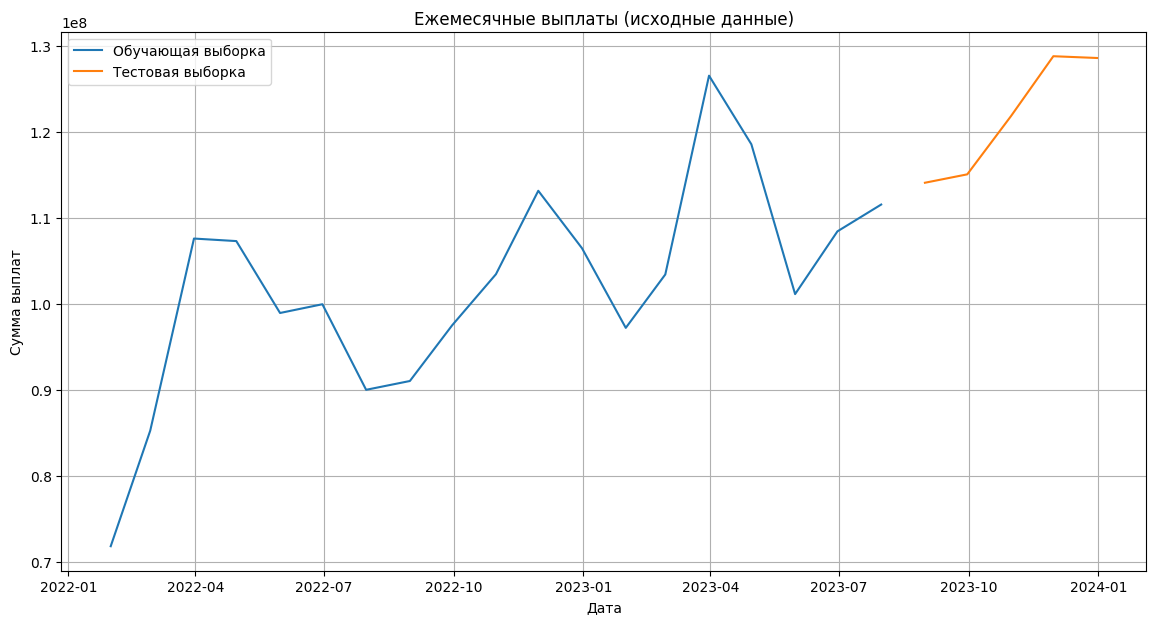


5. Анализ тренда и сезонности...
Недостаточно данных для декомпозиции. Требуется 24+ наблюдений, доступно 19


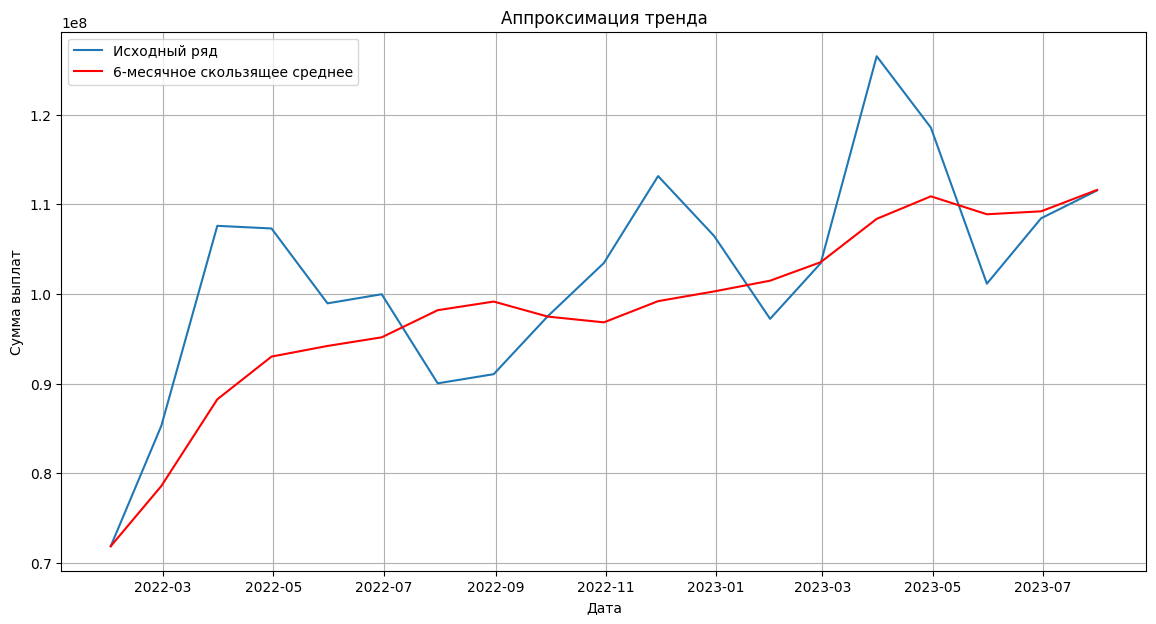

[I 2025-03-31 08:24:58,418] A new study created in memory with name: no-name-0c1f0990-b2f7-4d76-a15f-ed4aac9fda82
[I 2025-03-31 08:24:58,430] Trial 0 finished with value: 0.2669428095030805 and parameters: {'degree': 2}. Best is trial 0 with value: 0.2669428095030805.
[I 2025-03-31 08:24:58,437] Trial 1 finished with value: 0.47316896307277956 and parameters: {'degree': 4}. Best is trial 0 with value: 0.2669428095030805.
[I 2025-03-31 08:24:58,443] Trial 2 finished with value: 0.6589996505821901 and parameters: {'degree': 3}. Best is trial 0 with value: 0.2669428095030805.
[I 2025-03-31 08:24:58,452] Trial 3 finished with value: 0.6589996505821901 and parameters: {'degree': 3}. Best is trial 0 with value: 0.2669428095030805.
[I 2025-03-31 08:24:58,454] Trial 4 finished with value: 186.8313263868862 and parameters: {'degree': 5}. Best is trial 0 with value: 0.2669428095030805.
[I 2025-03-31 08:24:58,465] Trial 5 finished with value: 186.8313263868862 and parameters: {'degree': 5}. Best 


6. Линейная регрессия на тренде...

7. Подбор полиномиальной регрессии с Optuna...
Лучшая степень полинома: 2

8. Регрессия с сезонными фичами...

Подбор лучшей степени полинома для сезонной модели...
Лучшая степень полинома для сезонной модели: 1

9. Сравнение всех моделей...


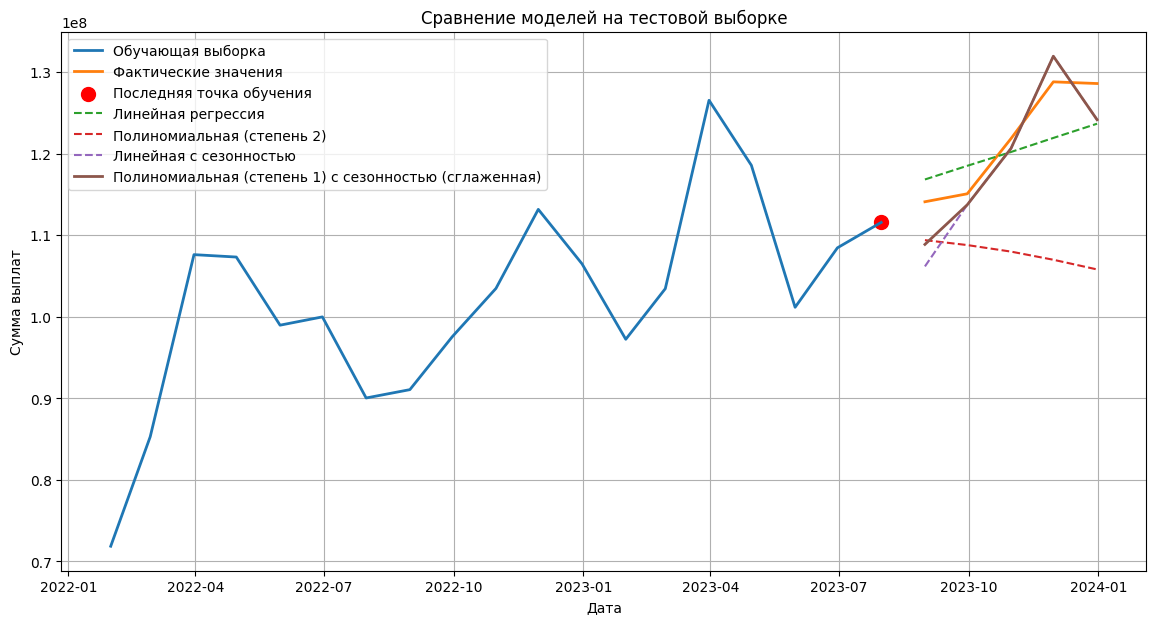


Метрики качества линейной модели:
MAE: 3922465.36
RMSE: 4325007.02
MAPE: 3.18%

Метрики качества полиномиальной модели (степень 2):
MAE: 13891849.94
RMSE: 15805696.32
MAPE: 11.13%

Метрики качества линейной модели с сезонностью:
MAE: 3612628.86
RMSE: 4374972.66
MAPE: 3.00%

Метрики качества полиномиальной модели с сезонностью (степень 1, сглаженная):
MAE: 3073138.02
RMSE: 3470228.67
MAPE: 2.53%

11. Прогноз на будущие периоды без усреднения...


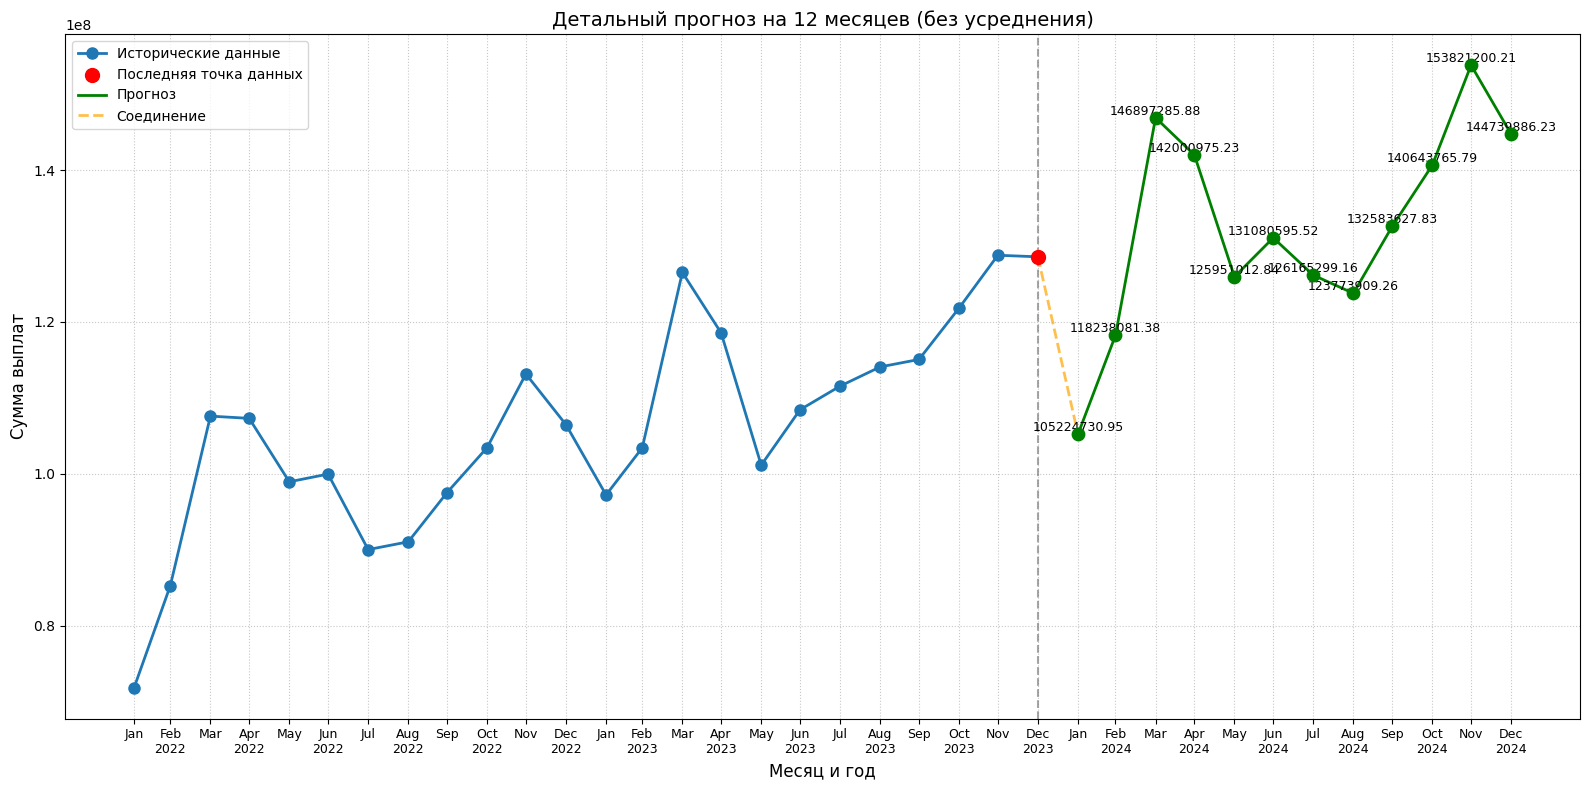


Прогноз на будущие периоды:
   date      прогноз
2024-01 1.052247e+08
2024-02 1.182381e+08
2024-03 1.468973e+08
2024-04 1.420010e+08
2024-05 1.259510e+08
2024-06 1.310806e+08
2024-07 1.261653e+08
2024-08 1.237739e+08
2024-09 1.325836e+08
2024-10 1.406438e+08
2024-11 1.538212e+08
2024-12 1.447399e+08

12. Сохранение результатов...
Прогноз сохранен в файл 'seasonal_poly_forecast.csv'


In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import DeterministicProcess

warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных
print("1. Загрузка и подготовка данных...")
data = pd.read_csv(r"D:\repositories\cup_it_25\CupIT_Sber_data.csv", delimiter=";")

# Преобразование и очистка данных
data['service_amount_net'] = pd.to_numeric(data['service_amount_net'].str.replace(',', '.'), errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'])
data = data.dropna(subset=['service_date', 'service_amount_net'])

# 2. Агрегация по месяцам и логарифмирование
print("\n2. Агрегация данных по месяцам...")
monthly_data = data.resample('M', on='service_date')['service_amount_net'].sum().to_frame('total_payments')
monthly_data = monthly_data[monthly_data['total_payments'] > 0]

# Логарифмирование для стабилизации дисперсии
monthly_data['log_payments'] = np.log(monthly_data['total_payments'])

# 3. Разделение на train/test
train_size = int(len(monthly_data) * 0.8)
train, test = monthly_data.iloc[:train_size], monthly_data.iloc[train_size:]

# 4. Визуализация временного ряда
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['total_payments'], label='Обучающая выборка')
plt.plot(test.index, test['total_payments'], label='Тестовая выборка')
plt.title('Ежемесячные выплаты (исходные данные)')
plt.xlabel('Дата')
plt.ylabel('Сумма выплат')
plt.legend()
plt.grid(True)
plt.show()

# 5. Анализ тренда и сезонности
print("\n5. Анализ тренда и сезонности...")
if len(train) >= 24:
    try:
        decomposition = seasonal_decompose(train['log_payments'], model='additive', period=12)
        decomposition.plot()
        plt.tight_layout()
        plt.show()
    except:
        print("Не удалось выполнить декомпозицию, используем скользящие средние...")
else:
    print(f"Недостаточно данных для декомпозиции. Требуется 24+ наблюдений, доступно {len(train)}")

# Визуализация тренда через скользящие средние
plt.figure(figsize=(14, 7))
train['ma_6'] = train['total_payments'].rolling(window=6, min_periods=1).mean()
plt.plot(train.index, train['total_payments'], label='Исходный ряд')
plt.plot(train.index, train['ma_6'], label='6-месячное скользящее среднее', color='red')
plt.title('Аппроксимация тренда')
plt.xlabel('Дата')
plt.ylabel('Сумма выплат')
plt.legend()
plt.grid(True)
plt.show()

# 6. Линейная регрессия на тренде
print("\n6. Линейная регрессия на тренде...")
dp = DeterministicProcess(index=train.index, constant=True, order=1, drop=True)
X_train = dp.in_sample()
y_train = train['log_payments']

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

X_test = dp.out_of_sample(steps=len(test))
linear_pred = linear_model.predict(X_test)
test['linear_forecast'] = np.exp(linear_pred)

# 7. Полиномиальная регрессия с подбором степени через Optuna
print("\n7. Подбор полиномиальной регрессии с Optuna...")
X_train_poly = np.arange(len(train)).reshape(-1, 1)
y_train_poly = train['log_payments'].values

def objective(trial):
    degree = trial.suggest_int('degree', 1, 5)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train_poly):
        X_train_cv, X_val_cv = X_train_poly[train_idx], X_train_poly[val_idx]
        y_train_cv, y_val_cv = y_train_poly[train_idx], y_train_poly[val_idx]
        
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)
        score = mean_squared_error(y_val_cv, y_pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_degree = study.best_params['degree']
print(f"Лучшая степень полинома: {best_degree}")

best_poly_model = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
best_poly_model.fit(X_train_poly, y_train_poly)

X_test_poly = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
poly_pred = best_poly_model.predict(X_test_poly)
test['poly_forecast'] = np.exp(poly_pred)

# 8. Регрессия с сезонными фичами (линейная и полиномиальная)
print("\n8. Регрессия с сезонными фичами...")

def add_seasonal_features(df):
    df = df.copy()
    df['month'] = df.index.month
    return df

train_seasonal = add_seasonal_features(train)
test_seasonal = add_seasonal_features(test)

# One-hot encoding для месяцев
all_months = pd.DataFrame({'month': range(1, 13)})
train_dummies = pd.get_dummies(train_seasonal['month'], prefix='month').reindex(
    columns=[f'month_{i}' for i in range(1, 13)], fill_value=0)
test_dummies = pd.get_dummies(test_seasonal['month'], prefix='month').reindex(
    columns=[f'month_{i}' for i in range(1, 13)], fill_value=0)

# Добавление тренда
X_train_seasonal = train_dummies.copy()
X_train_seasonal['trend'] = np.arange(len(train_seasonal))
y_train_seasonal = train_seasonal['log_payments']

X_test_seasonal = test_dummies.copy()
X_test_seasonal['trend'] = np.arange(len(train_seasonal), len(train_seasonal) + len(test_seasonal))

# 8.1 Линейная регрессия с сезонными фичами
linear_seasonal_model = LinearRegression()
linear_seasonal_model.fit(X_train_seasonal, y_train_seasonal)
linear_seasonal_pred = linear_seasonal_model.predict(X_test_seasonal)
test['linear_seasonal_forecast'] = np.exp(linear_seasonal_pred)

# 8.2 Полиномиальная регрессия с сезонными фичами
print("\nПодбор лучшей степени полинома для сезонной модели...")

def objective_seasonal(trial):
    degree = trial.suggest_int('degree', 1, 3)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_train_seasonal[['trend']])
    X_poly_seasonal = np.concatenate([X_train_seasonal.drop(columns=['trend']).values, X_poly], axis=1)
    
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_poly_seasonal):
        X_train_cv, X_val_cv = X_poly_seasonal[train_idx], X_poly_seasonal[val_idx]
        y_train_cv, y_val_cv = y_train_seasonal.iloc[train_idx], y_train_seasonal.iloc[val_idx]
        
        model = LinearRegression()
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)
        score = mean_squared_error(y_val_cv, y_pred)
        scores.append(score)
    
    return np.mean(scores)

study_seasonal = optuna.create_study(direction='minimize')
study_seasonal.optimize(objective_seasonal, n_trials=5)

best_seasonal_degree = study_seasonal.best_params['degree']
print(f"Лучшая степень полинома для сезонной модели: {best_seasonal_degree}")

# Обучение лучшей полиномиальной модели с сезонностью
poly = PolynomialFeatures(degree=best_seasonal_degree, include_bias=False)
X_train_poly_seasonal = np.concatenate([
    X_train_seasonal.drop(columns=['trend']).values,
    poly.fit_transform(X_train_seasonal[['trend']])
], axis=1)

poly_seasonal_model = LinearRegression()
poly_seasonal_model.fit(X_train_poly_seasonal, y_train_seasonal)

# Подготовка тестовых данных
X_test_poly_seasonal = np.concatenate([
    X_test_seasonal.drop(columns=['trend']).values,
    poly.transform(X_test_seasonal[['trend']])
], axis=1)

# Прогнозирование с усреднением первой точки
poly_seasonal_pred = poly_seasonal_model.predict(X_test_poly_seasonal)
test['poly_seasonal_forecast'] = np.exp(poly_seasonal_pred)

# Усреднение последней исторической точки и первого прогноза
last_actual = train['total_payments'].iloc[-1]
first_forecast = test['poly_seasonal_forecast'].iloc[0]
smoothed_value = (last_actual + first_forecast) / 2

# Заменяем первое прогнозное значение на усредненное
test['poly_seasonal_forecast_smoothed'] = test['poly_seasonal_forecast'].copy()
test['poly_seasonal_forecast_smoothed'].iloc[0] = smoothed_value

# 9. Сравнение всех моделей
print("\n9. Сравнение всех моделей...")

plt.figure(figsize=(14, 7))
plt.plot(train.index, train['total_payments'], label='Обучающая выборка', linewidth=2)
plt.plot(test.index, test['total_payments'], label='Фактические значения', linewidth=2)

# Отмечаем последнюю точку обучающей выборки
plt.scatter(train.index[-1], train['total_payments'].iloc[-1], color='red', s=100, label='Последняя точка обучения')

# Прогнозы
plt.plot(test.index, test['linear_forecast'], label='Линейная регрессия', linestyle='--')
plt.plot(test.index, test['poly_forecast'], label=f'Полиномиальная (степень {best_degree})', linestyle='--')
plt.plot(test.index, test['linear_seasonal_forecast'], label='Линейная с сезонностью', linestyle='--')
plt.plot(test.index, test['poly_seasonal_forecast_smoothed'], 
         label=f'Полиномиальная (степень {best_seasonal_degree}) с сезонностью (сглаженная)', 
         linestyle='-', linewidth=2)

plt.title('Сравнение моделей на тестовой выборке')
plt.xlabel('Дата')
plt.ylabel('Сумма выплат')
plt.legend()
plt.grid(True)
plt.show()

# 10. Метрики качества
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\nМетрики качества {model_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

print_metrics(test['total_payments'], test['linear_forecast'], "линейной модели")
print_metrics(test['total_payments'], test['poly_forecast'], f"полиномиальной модели (степень {best_degree})")
print_metrics(test['total_payments'], test['linear_seasonal_forecast'], "линейной модели с сезонностью")
print_metrics(test['total_payments'], test['poly_seasonal_forecast_smoothed'], 
             f"полиномиальной модели с сезонностью (степень {best_seasonal_degree}, сглаженная)")

print("\n11. Прогноз на будущие периоды без усреднения...")
future_steps = 12
last_date = monthly_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                           periods=future_steps, freq='M')

# Подготовка фичей для будущего прогноза
future_dummies = pd.get_dummies(pd.Series(future_dates.month, name='month'), 
                              prefix='month').reindex(
                                  columns=[f'month_{i}' for i in range(1, 13)], 
                                  fill_value=0)
future_features = pd.DataFrame({
    'trend': np.arange(len(monthly_data), len(monthly_data) + future_steps)
})

# Преобразуем для полиномиальной модели
X_future_poly_seasonal = np.concatenate([
    future_dummies.values,
    poly.transform(future_features[['trend']])
], axis=1)

# Прогнозирование
future_pred = poly_seasonal_model.predict(X_future_poly_seasonal)
future_forecast = np.exp(future_pred)

# Создаем DataFrame с прогнозом
forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecast': future_forecast
})

# Визуализация с соединением последней точки и первого прогноза
plt.figure(figsize=(16, 8))

# Исторические данные с точками
plt.plot(monthly_data.index, monthly_data['total_payments'], 
        label='Исторические данные', linewidth=2, marker='o', markersize=8)

# Последняя историческая точка (выделяем красным)
last_point = monthly_data.index[-1]
last_value = monthly_data['total_payments'].iloc[-1]
plt.scatter(last_point, last_value, color='red', s=100, zorder=5, 
           label='Последняя точка данных')

# Прогнозные данные с точками
forecast_line, = plt.plot(forecast_df['date'], forecast_df['forecast'], 
                         label='Прогноз', linestyle='-', linewidth=2, color='green')
plt.scatter(forecast_df['date'], forecast_df['forecast'],
           color='green', s=80, zorder=5)

# Соединяем последнюю историческую точку с первой прогнозной
connection_line, = plt.plot([last_point, forecast_df['date'].iloc[0]], 
                          [last_value, forecast_df['forecast'].iloc[0]],
                          linestyle='--', color='orange', linewidth=2, alpha=0.7, 
                          label='Соединение')

# Добавляем подписи значений для прогноза
for i, row in forecast_df.iterrows():
    plt.text(row['date'], row['forecast'], 
             f"{row['forecast']:.2f}",
             ha='center', va='bottom', fontsize=9)

# Настройка оси X для отображения всех месяцев
all_dates = pd.concat([monthly_data.index.to_series(), forecast_df['date']])
plt.xticks(
    all_dates,
    [date.strftime('%b\n%Y') if date.month % 2 == 0 else date.strftime('%b') for date in all_dates],
    rotation=0,
    fontsize=9
)

# Вертикальная линия разделения истории и прогноза
plt.axvline(x=monthly_data.index[-1], color='gray', linestyle='--', alpha=0.7)

plt.title(f'Детальный прогноз на {future_steps} месяцев (без усреднения)', fontsize=14)
plt.xlabel('Месяц и год', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# Выводим прогноз по месяцам
print("\nПрогноз на будущие периоды:")
forecast_display = forecast_df.copy()
forecast_display['date'] = forecast_display['date'].dt.strftime('%Y-%m')
print(forecast_display[['date', 'forecast']].rename(
    columns={'forecast': 'прогноз'}).to_string(index=False))

# 12. Сохранение результатов
print("\n12. Сохранение результатов...")
forecast_df.to_csv('seasonal_poly_forecast.csv', index=False)
print("Прогноз сохранен в файл 'seasonal_poly_forecast.csv'")

**Вывод**: Гипотеза оправдалась. Высокая точность апроксимации кривой на тестовой выборке и оторажение сезонности, трендов на 2024 год

### Попробуем применить данный подход к агрегации по неделям

2. Обучение модели на всех доступных данных...
5. Создание прогноза на 52 недели...


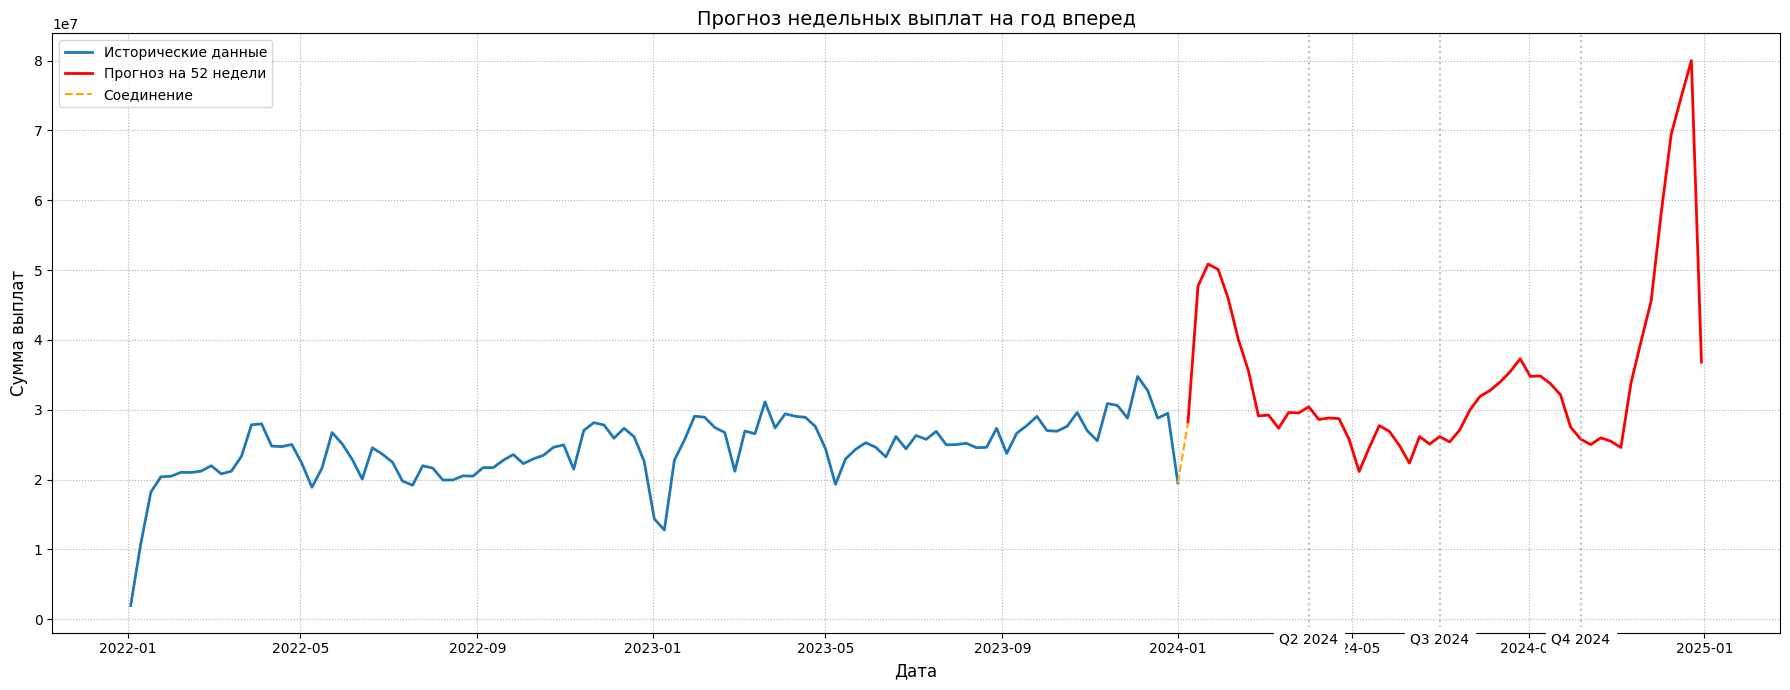


Первые 5 недель прогноза:
      date  week_of_year     forecast
2024-01-08             2 2.813029e+07
2024-01-15             3 4.770940e+07
2024-01-22             4 5.086356e+07
2024-01-29             5 5.010585e+07
2024-02-05             6 4.591985e+07

Прогноз сохранен в yearly_weekly_forecast.csv


In [19]:
# Улучшенный пайплайн с корректными размерностями и обучением на всех данных

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных
def load_and_preprocess(filepath):
    data = pd.read_csv(filepath, delimiter=";")
    data['service_amount_net'] = pd.to_numeric(data['service_amount_net'].str.replace(',', '.'), errors='coerce')
    data['service_date'] = pd.to_datetime(data['service_date'])
    data = data.dropna(subset=['service_date', 'service_amount_net'])
    
    # Агрегация по неделям с интерполяцией
    weekly_data = data.resample('W-Mon', on='service_date')['service_amount_net'].sum().to_frame('total_payments')
    weekly_data['total_payments'] = weekly_data['total_payments'].replace(0, np.nan).interpolate(method='time')
    weekly_data['log_payments'] = np.log(weekly_data['total_payments'])
    
    return weekly_data

weekly_data = load_and_preprocess(r"D:\repositories\cup_it_25\CupIT_Sber_data.csv")

# 2. Построение модели на ВСЕХ данных (как вы просили)
print("2. Обучение модели на всех доступных данных...")

def prepare_features(data):
    data = data.copy()
    data['week_of_year'] = data.index.isocalendar().week
    data['week_num'] = np.arange(len(data))
    
    # One-hot encoding для недель
    dummy_cols = [f'week_{i}' for i in range(1, 53)]
    week_dummies = pd.get_dummies(data['week_of_year'], prefix='week').reindex(columns=dummy_cols, fill_value=0)
    
    # Детерминированный процесс
    fourier = CalendarFourier(freq='A', order=3)
    dp = DeterministicProcess(
        index=data.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )
    
    X = dp.in_sample()
    X = pd.concat([X, week_dummies], axis=1)
    y = data['log_payments']
    
    return X, y, dp

X_all, y_all, dp = prepare_features(weekly_data)

# 3. Обучение модели
model = LinearRegression()
model.fit(X_all, y_all)

# 4. Функция для прогнозирования
def make_forecast(model, dp, last_date, steps):
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(weeks=1),
        periods=steps,
        freq='W-Mon'
    )
    
    X_future = dp.out_of_sample(steps=steps)
    future_weeks = pd.Series(future_dates.isocalendar().week, name='week')
    
    dummy_cols = [f'week_{i}' for i in range(1, 53)]
    future_dummies = pd.get_dummies(future_weeks, prefix='week').reindex(columns=dummy_cols, fill_value=0)
    
    X_future = pd.concat([X_future, future_dummies], axis=1).fillna(0)
    predictions = np.exp(model.predict(X_future))
    
    return future_dates, predictions

# 5. Прогноз на 52 недели
print("5. Создание прогноза на 52 недели...")
future_dates, future_forecast = make_forecast(
    model, dp, weekly_data.index[-1], 52
)

# 6. Визуализация
plt.figure(figsize=(18, 7))

# Последние 2 года для контекста
plot_start = weekly_data.index[-1] - pd.DateOffset(weeks=104)
historical_to_plot = weekly_data[weekly_data.index >= plot_start]

plt.plot(historical_to_plot.index, 
         historical_to_plot['total_payments'], 
         label='Исторические данные', linewidth=2)

# Прогноз
plt.plot(future_dates, 
         future_forecast, 
         label='Прогноз на 52 недели', 
         color='red', linewidth=2)

# Соединение
plt.plot([weekly_data.index[-1], future_dates[0]],
         [weekly_data['total_payments'].iloc[-1], future_forecast[0]],
         '--', color='orange', label='Соединение')

# Настройки графика
plt.title('Прогноз недельных выплат на год вперед', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':')

# Разметка кварталов
for i, date in enumerate(future_dates):
    if date.month in [1, 4, 7, 10] and date.day < 8:  # Первые недели кварталов
        plt.axvline(x=date, color='gray', linestyle=':', alpha=0.5)
        plt.text(date, plt.ylim()[0], f"Q{(date.month-1)//3 + 1} {date.year}",
                ha='center', va='top', backgroundcolor='white')

plt.tight_layout()
plt.show()

# 7. Сохранение результатов
forecast_df = pd.DataFrame({
    'date': future_dates,
    'week_of_year': future_dates.isocalendar().week,
    'forecast': future_forecast
})

print("\nПервые 5 недель прогноза:")
print(forecast_df.head().to_string(index=False))

forecast_df.to_csv('yearly_weekly_forecast.csv', index=False)
print("\nПрогноз сохранен в yearly_weekly_forecast.csv")

**Вывод**: гипотеза не оправдалась. Агрегация по неделям имеет много "шума" - подход с апроксимированием кривой линейными регрессиями в данном случае не подходит

Прведение теста Льюнга-Бокса

In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Получение остатков лучшей модели (полиномиальной с сезонностью)
residuals = test['total_payments'] - test['poly_seasonal_forecast_smoothed']

# Автоматический подбор максимального количества лагов (не более длины остатков)
max_possible_lags = min(10, len(residuals) - 1)  # Не больше 10 и не больше len(residuals)-1

# Тест Льюнга-Бокса
if max_possible_lags > 0:
    lb_test = acorr_ljungbox(residuals, lags=max_possible_lags, return_df=True)
    print("\nРезультаты теста Льюнга-Бокса для остатков:")
    print(lb_test)
    
    # p-value для последнего доступного лага
    p_value = lb_test['lb_pvalue'].iloc[-1]
    print(f"\np-value: {p_value:.4f}")
    
    # Вывод по корреляции остатков
    if p_value > 0.05:
        print("\nВывод: p-value > 0.05, нет оснований отвергать нулевую гипотезу. Остатки не демонстрируют значимой автокорреляции, что указывает на хорошее качество модели.")
    else:
        print("\nВывод: p-value ≤ 0.05, отвергаем нулевую гипотезу. Остатки демонстрируют значимую автокорреляцию, что указывает на неучтенные закономерности в модели.")
else:
    print("\nНедостаточно данных для выполнения теста Льюнга-Бокса (требуется минимум 2 наблюдения).")


Результаты теста Льюнга-Бокса для остатков:
    lb_stat  lb_pvalue
1  0.583807   0.444824
2  0.595311   0.742557
3  3.612428   0.306471
4  5.082225   0.278964

p-value: 0.2790

Вывод: p-value > 0.05, нет оснований отвергать нулевую гипотезу. Остатки не демонстрируют значимой автокорреляции, что указывает на хорошее качество модели.
